In [1]:
import numpy as np
import pandas as pd

frame = pd.read_excel("data_gdm_discrete_BMI_merged.xlsx", engine="openpyxl")
frame.oDM = (frame.oDM == 2).astype(int)
for name in frame.columns:
    frame[name] = frame[name].astype('category')

print (frame)
print (frame.oDM.value_counts())

     AgeCat BMICat Race Education GravCat SmokeCat1 SmokeCat2 oDM
0         3      0    1         3       2         1         1   0
1         1      2    2         2       1         1         2   0
2         0      0    2         1       1         2         2   0
3         2      2    3         3       2         2         2   0
4         1      0    3         4       1         2         2   0
...     ...    ...  ...       ...     ...       ...       ...  ..
9215      2      1    1         4       2         1         1   0
9216      1      0    3         3       2         2         2   0
9217      0      0    3         1       2         2         2   0
9218      2      1    1         2       3         1         1   0
9219      3      2    1         5       1         1         1   0

[9220 rows x 8 columns]
0    8832
1     388
Name: oDM, dtype: int64


In [2]:
from imblearn.under_sampling import NearMiss

ros = NearMiss()
X_res, y_res = ros.fit_resample(frame.drop('oDM', axis=1), frame.oDM)
X_res['oDM'] = y_res
frame = X_res

print (frame)

    AgeCat BMICat Race Education GravCat SmokeCat1 SmokeCat2 oDM
0        4      1    1         3       1         1         1   0
1        3      1    1         6       1         2         2   0
2        4      1    1         5       1         1         2   0
3        4      1    1         5       1         1         2   0
4        1      2    1         4       1         2         2   0
..     ...    ...  ...       ...     ...       ...       ...  ..
771      1      1    1         4       1         2         2   1
772      3      2    1         3       2         1         2   1
773      2      2    1         5       1         1         2   1
774      4      2    1         3       1         1         2   1
775      2      2    3         4       1         2         2   1

[776 rows x 8 columns]


In [3]:
from sklearn.model_selection import StratifiedKFold
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
import warnings 

train_data = frame.to_numpy()
names = frame.columns.tolist()
categories = ['Race', 'oDM']
ptypes = [Categorical if n in categories else Gaussian for n in names]
categorical = [n in categories for n in names]

In [4]:
from spn.algorithms.Inference import log_likelihood

for n in [20, 40, 60, 80, 100]:
    splitter = StratifiedKFold()
    ll = []
    for train_i, test_i in splitter.split(train_data, train_data[:, -1]):
        train = train_data[train_i]
        test = train_data[test_i]
        
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            context = Context(parametric_types = ptypes).add_domains(train)
            net = learn_parametric(train,
                                   ds_context = context,
                                   min_instances_slice = n)
            l = log_likelihood(net, test)
            ll.append(-np.sum(l))

    print ("%6d %8.4f ± %8.4f" % (n, np.mean(ll), np.std(ll)))

    20 -4953.1845 ± 1641.3029
    40 -4187.7725 ± 2172.6243
    60 -4184.4695 ± 2171.9600
    80 -4032.1425 ± 2016.2867
   100 -3622.6186 ± 2319.3703


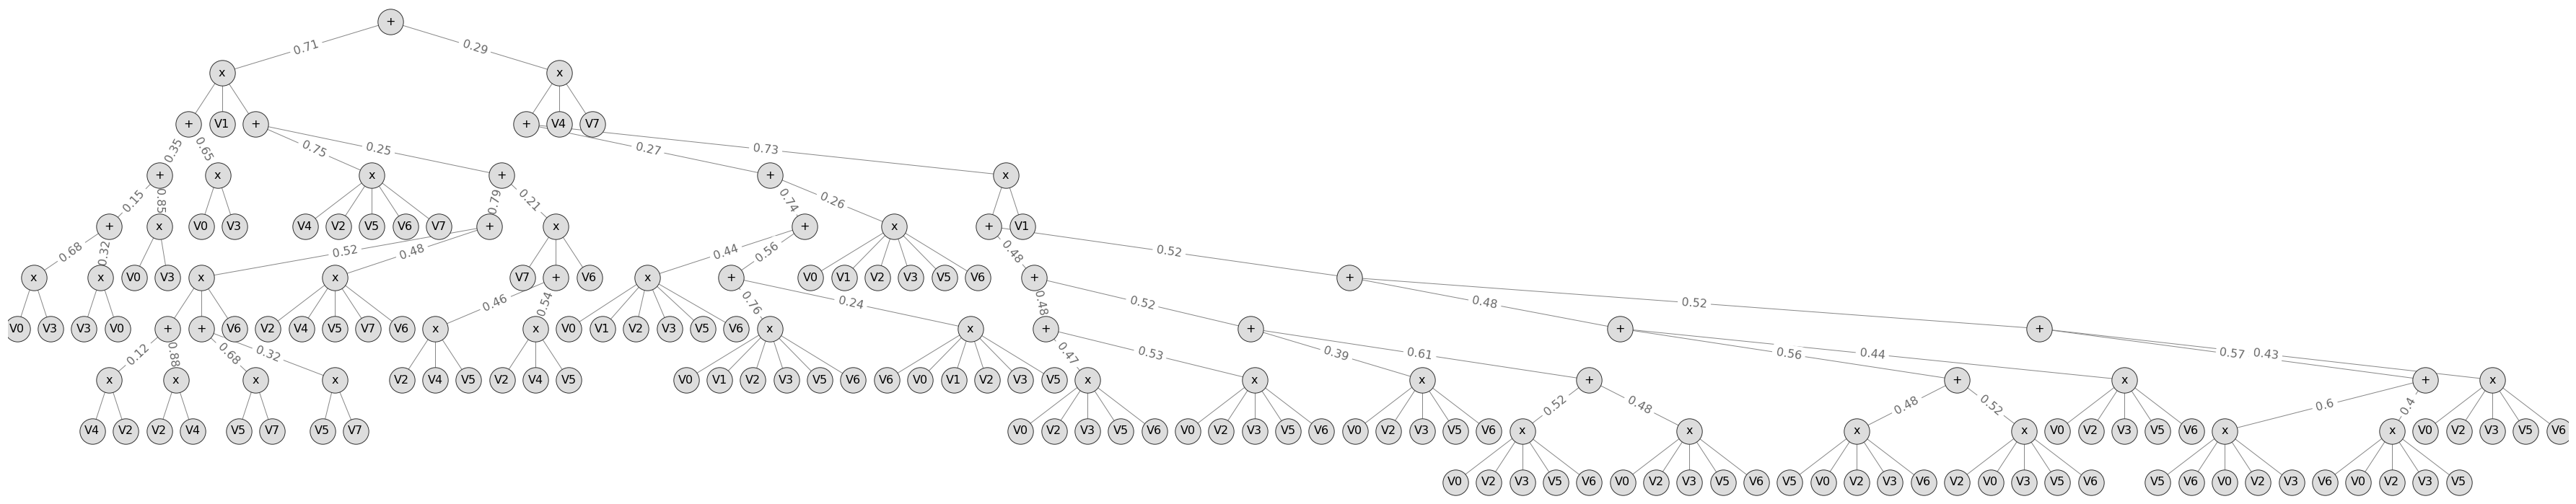

In [5]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    context =  Context(parametric_types=ptypes).add_domains(train_data)
    net = learn_parametric(train_data, 
                           ds_context = context, 
                           min_instances_slice = 20)

plt.figure(figsize=(50, 10))
plot_spn(net)

In [6]:
from csi import annotate, context_specific_independences

annotate(net, names, categorical, min_impurity_decrease=0.1)
for rule in context_specific_independences(net):
    print (rule)

([['Education > 4.5']], [['AgeCat', 'Education'], ['BMICat'], ['Race', 'GravCat', 'SmokeCat1', 'SmokeCat2', 'oDM']], 0.9237749546279492)
([['Education <= 4.5']], [['AgeCat', 'BMICat', 'Race', 'Education', 'SmokeCat1', 'SmokeCat2'], ['GravCat'], ['oDM']], 0.7955555555555556)
([['Education > 4.5'], ['AgeCat > 2.5']], [['AgeCat'], ['Education']], 0.9237749546279492)
([['Education > 4.5'], ['oDM == 0']], [['GravCat'], ['Race'], ['SmokeCat1'], ['SmokeCat2'], ['oDM']], 0.7883175694541393)
([['Education <= 4.5'], ['Race != 5 and Race != 8']], [['AgeCat', 'Race', 'Education', 'SmokeCat1', 'SmokeCat2'], ['BMICat']], 0.7858536585365854)
([['Education > 4.5'], ['AgeCat <= 2.5'], ['AgeCat <= 3.5']], [['AgeCat'], ['Education']], 0.5839406448943514)
([['Education > 4.5'], ['oDM != 0'], ['Race != 1']], [['oDM'], ['Race', 'GravCat', 'SmokeCat1'], ['SmokeCat2']], 0.8416616253276871)
([['Education > 4.5'], ['oDM != 0'], ['Race == 1'], ['GravCat > 1.5']], [['Race', 'GravCat'], ['SmokeCat1', 'oDM'], ['Smo